In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [50]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures):
    ratings = {}
    league_ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
    
    # Initialize ratings for each competition
    league_ratings['REST'] = {
        'brH': 0.0,
        'brA': 0.0,
        'continuous_overunderperformances': 0
    }
    
    for competition in competitions:
        league_ratings[competition] = {
            'brH': 0.0,
            'brA': 0.0,
            'continuous_overunderperformances': 0
        }

    #print('Teams:', teams, end='\n\n')
    return ratings, league_ratings


In [51]:
def initialize_rest_ratings(rest_teams):
    rest_ratings = {}
    for team in rest_teams:
        rest_ratings[team] = {
            'REST': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
        }
    return rest_ratings

In [52]:
def create_team_to_league_mapping(df_results, df_fixtures, df_int):
    team_to_league = {}
    rest_teams = set() # To store teams that are assigned to the 'REST' league

    def get_league_level(division):
        # Special handling for 'EC' league
        if division == 'EC':
            return 5
        # Extracting the integer part from the division
        integer_part = ''.join(filter(str.isdigit, division))
        return int(integer_part)


    # Iterate through the results and fixtures dataframes and map teams to their leagues
    for df in [df_results, df_fixtures]:
        for index, row in df.iterrows():
            for team in [row['HomeTeam'], row['AwayTeam']]:
                current_div = row['Div']
                current_level = get_league_level(current_div)

                # If the team is not yet in the dictionary, or if the current league is higher, update the entry
                if team not in team_to_league or current_level < get_league_level(team_to_league[team]):
                    team_to_league[team] = current_div

    # Now process df_int
    for index, row in df_int.iterrows():
        for team in [row['HomeTeam'], row['AwayTeam']]:
            if team not in team_to_league:
                # If the team is not found in the other dataframes, assign it to 'REST'
                team_to_league[team] = 'REST'
                rest_teams.add(team)

    return team_to_league, rest_teams

In [53]:
def get_league_from_team(team, team_to_league):
    return team_to_league.get(team, 'REST')

In [54]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, rates):
    ind_threshold = rates['ind_threshold']
    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > ind_threshold:
            #add current game to training data
            training_games.append({
                "brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                "brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                "prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0],
                "prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[1],
                "brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                "brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                "prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[0],
                "prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1]),
                "FTHG": row["FTHG"],
                "FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })


        if np.isnan(ratings[row["HomeTeam"]][competition]["brH"]):
            print("error")
            break

        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, rates, competition)

        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [55]:
def update_league_ratings_multiple_games(df_int_results, league_ratings, team_to_league, rates):
    # Iterate over each match in the international results data
    for index, row in df_int_results.iterrows():
        # Extract relevant information from the row
        HomeLeague = get_league_from_team(row['HomeTeam'], team_to_league)
        AwayLeague = get_league_from_team(row['AwayTeam'], team_to_league)
        FTHG = row['FTHG']
        FTAG = row['FTAG']

        # Update the league ratings based on the match result
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, FTHG, FTAG, league_ratings, rates)

    return league_ratings


In [56]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, rates, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [57]:
# Function to update ratings based on results data
def update_league_ratings_single_game(HomeLeague, AwayLeague, FTHG, FTAG, league_ratings, rates):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda2']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma2']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(league_ratings[HomeLeague]['brH']) / 3
    expected_goal_x = np.sign(league_ratings[HomeLeague]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(league_ratings[AwayLeague]['brA']) / 3
    expected_goal_y = np.sign(league_ratings[AwayLeague]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = league_ratings[HomeLeague]['brH']
    previous_away_rating_x = league_ratings[HomeLeague]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    league_ratings[HomeLeague]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    league_ratings[HomeLeague]['brA'] = previous_away_rating_x + (league_ratings[HomeLeague]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = league_ratings[AwayLeague]['brH']
    previous_away_rating_y = league_ratings[AwayLeague]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    league_ratings[AwayLeague]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    league_ratings[AwayLeague]['brH'] = previous_home_rating_y + (league_ratings[AwayLeague]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        league_ratings[HomeLeague]['continuous_overunderperformances'] = max(1, league_ratings[HomeLeague]['continuous_overunderperformances'] + 1)
        league_ratings[AwayLeague]['continuous_overunderperformances'] = min(-1, league_ratings[AwayLeague]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        league_ratings[HomeLeague]['continuous_overunderperformances'] = min(-1, league_ratings[HomeLeague]['continuous_overunderperformances'] - 1)
        league_ratings[AwayLeague]['continuous_overunderperformances'] = max(1, league_ratings[AwayLeague]['continuous_overunderperformances'] + 1)
    else:
        league_ratings[HomeLeague]['continuous_overunderperformances'] = 0
        league_ratings[AwayLeague]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return league_ratings


In [58]:
def calculate_provisional_ratings(ratings, team, competition, rates):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    #form_threshold_phi = 1
    form_threshold_phi = rates['phi']

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    #rating_impact_mu = 0.01
    rating_impact_mu = rates['mu']

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    #diminishing_factor_delta = 2.5
    diminishing_factor_delta = rates['delta']

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away
    prH = brH
    prA = brA

    #return prH, prA

    if abs(ratings[team][competition]['continuous_overunderperformances']) < (form_threshold_phi + 1):
        return prH, prA

    # Calculate performance factor for home team x
    a = abs(ratings[team][competition]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team][competition]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    if (ratings[team][competition]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home

    return prH, prA

In [59]:
def calculate_probabilities(features, model):

    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [60]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, team_to_league, rates):
    rho = rates['rho']
    sigma = rates['sigma']
    
    competition1 = competition
    competition2 = competition
    if competition == 'INT0':
        competition1 = get_league_from_team(HomeTeam, team_to_league)
        competition2 = get_league_from_team(AwayTeam, team_to_league)
        
    # Calculate home team rating
    home_rating_x = ratings[HomeTeam][competition1]['brH']
    if (abs(ratings[HomeTeam][competition1]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition1, rates)
        home_rating_x = provisional_ratings_x[0]

    # Calculate away team rating
    away_rating_y = ratings[AwayTeam][competition2]['brA']
    if (abs(ratings[AwayTeam][competition2]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition2, rates)
        away_rating_y = provisional_ratings_y[1]
    
    if competition == 'INT0':
        home_rating_x = rho * home_rating_x + sigma * league_ratings[competition1]['brH']
        away_rating_y = rho * away_rating_y + sigma * league_ratings[competition2]['brA']

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [61]:
def predict_outcomes(df_fixtures, ratings, rates, model):
    
    all_rps = []
    league_ratings_fake = {}
    team_to_league_fake = {}

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']

        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])


        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings_fake, team_to_league_fake, rates)

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

        # Update league table
        league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)

        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, rates, competition)

    print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')

    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table

    return all_rps, league_tables


In [62]:
def predict_outcomes_int(df_int_fixtures, ratings, league_ratings, team_to_league, rates, model):

    int_rps = []
    
    for index, row in df_int_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        #HomeLeague = get_league_from_team(HomeTeam, team_to_league)
        #AwayLeague = get_league_from_team(AwayTeam, team_to_league)

        competition = row['Div']

        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, team_to_league, rates)

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n')
        """
        

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        int_rps.append(rps_score)

        # Update league_ratings
        #league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, row['FTHG'], row['FTAG'], league_ratings, rates)
        

    print(f"Average RPS Score for {competition}:", np.mean(int_rps), '\n')


    return int_rps

In [63]:
def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [64]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [65]:

def train_model(df_train):

    # Create Logistic Regression model
    #model = LogisticRegression(solver="saga", penalty="l2")  # 'ovr' stands for One-Vs-Rest
    model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000, random_state=23)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model


In [76]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('../data/season_2010-2022_sorted_compressed.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('../data/season_2022-2023_sorted_top.csv')

# Load the international results data file
df_int_results = pd.read_csv('../data/season_2016-2021_INT.csv')

# Load the international fixtures data file
df_int_fixtures = pd.read_csv('../data/season_2021-2022_INT.csv')

# Define the learning rates
rates = {
    'lambda': 0.037,
    'gamma': 0.99,
    'delta': 12,
    'phi': 2,
    'mu': 0.08,
    'rho': 0.475,
    'sigma': 1.05,
    'ind_threshold': 9000,
    'lambda2': 0.1,
    'gamma2': 1.0
}

# Map teams to leagues
df_int = pd.concat([df_int_results, df_int_fixtures], ignore_index=True)
team_to_league, rest_teams = create_team_to_league_mapping(df_results, df_fixtures, df_int)

# Initialize ratings based on the results data
ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
rest_ratings = initialize_rest_ratings(rest_teams)
ratings.update(rest_ratings)

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, rates)
#model.C_

# Train the model for predicting match outcomes
df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)



"""
# Create a reverse mapping of leagues to teams
league_to_teams = {}
for team, league in team_to_league.items():
    if league not in league_to_teams:
        league_to_teams[league] = []
    league_to_teams[league].append(team)

# Print the teams sorted by league
for league, teams in sorted(league_to_teams.items()):
    print(f"{league}:")
    print(", ".join(teams))
    print()
"""

# Update league ratings based on the results data here
league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, team_to_league, rates)
for league, values in league_ratings.items():
    print(f"League: {league}, Rating: {values['brH']}")

# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, rates, model)
    all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)


int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, team_to_league, rates, model)


;

League: REST, Rating: -0.3185893943435015
League: SC0, Rating: -0.9198471744110921
League: SP1, Rating: 0.8845539062836943
League: F2, Rating: -1.1114758321139095
League: T1, Rating: -0.7778688372683095
League: E1, Rating: -0.0630617724482484
League: E3, Rating: 0.0
League: SC2, Rating: 0.0
League: SP2, Rating: 0.3581981069156144
League: B1, Rating: -0.43835462068277137
League: P1, Rating: 0.1132632285461209
League: F1, Rating: 0.32277384081491034
League: N1, Rating: 0.6418080096983287
League: E2, Rating: 0.0
League: SC3, Rating: 0.0
League: I1, Rating: 0.3267641591047022
League: EC, Rating: -0.16788410825808509
League: D2, Rating: 0.0
League: E0, Rating: 1.3286568101201746
League: G1, Rating: -0.8242735002926561
League: D1, Rating: 0.6453371783350269
League: SC1, Rating: 0.0
League: I2, Rating: 0.0
Average RPS Score for B1: 0.20499772162731292 

Average RPS Score for SC0: 0.1867077442381349 
Average RPS Score for N1: 0.18246084718664696 

Average RPS Score for T1: 0.20443619968036755 

''

''

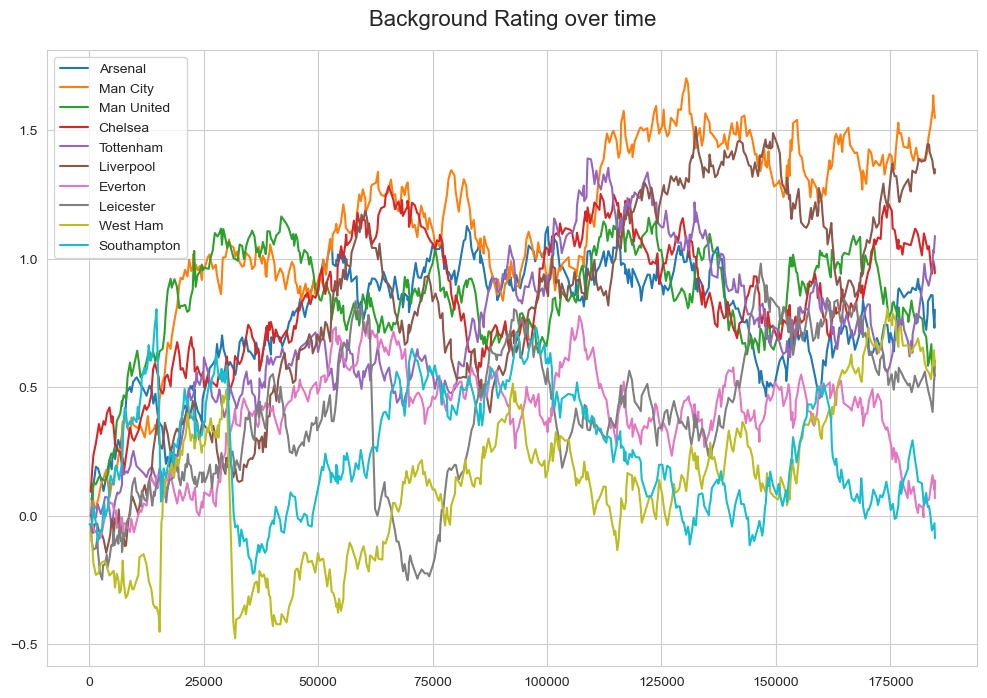

In [48]:

plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool", "Everton", "Leicester", "West Ham", "Southampton"]
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time232.png", dpi=300)

;

In [497]:
# Print league tables
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

League table for B1:
                   team games_played     points
1           Club Brugge           34  65.737283
2                  Genk           34  64.656836
3          St. Gilloise           34  64.219930
4               Antwerp           34  60.800512
5                  Gent           34  60.799659
6            Anderlecht           34  59.892608
7            St Truiden           34  47.679783
8             Charleroi           34  47.651280
9              Standard           34  45.796133
10        Cercle Brugge           34  45.231263
11             Mechelen           34  44.261285
12  Oud-Heverlee Leuven           34  42.490433
13             Kortrijk           34  36.710749
14             Westerlo           34  34.607680
15             Oostende           34  32.343848
16              Waregem           34  30.466394
17                Eupen           34  30.076036
18              Seraing           34  27.551227
League table for SC0:
             team games_played     points
1  

''

''

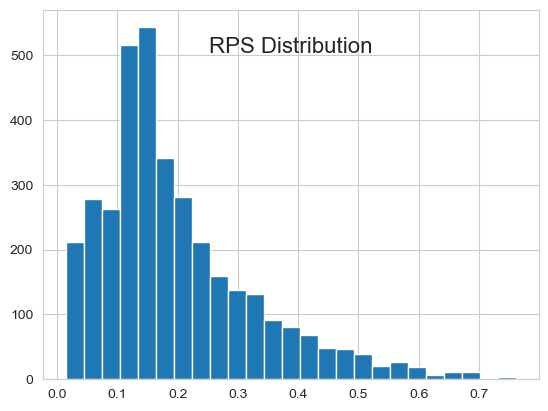

In [498]:
# Plot RPS distribution
plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=25)
plt.savefig("../images/rps_distribution232.png", dpi=300)



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

In [475]:
# Gridsearch on lambda and gamma

# Initialize the rates
rates = {
    'lambda': 0.037,
    'gamma': 0.99,
    'delta': 12,
    'phi': 2,
    'mu': 0.09,
    'rho': 0.325,
    'sigma': 1.05,
    'ind_threshold': 13500
}

# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda': np.linspace(0.03, 0.04, int((0.04 - 0.03) / 0.001) + 1),
    'gamma': np.linspace(0.95, 1.0, int((1.0 - 0.95) / 0.01) + 1)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
    
    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, rates)

    df_train = pd.DataFrame(training_games)
    df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, rates, model)
    score = np.mean(all_rps)

    # Store the current results
    gs_results.append({
        'lambda': rates['lambda'],
        'gamma': rates['gamma'],
        'score': score,
    })

# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda x: x['score'])[:5]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"Lambda: {combo['lambda']}, Gamma: {combo['gamma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them
df_gs_results = pd.DataFrame(gs_results)

# Define grid of x, y values
lambda_range = np.linspace(df_gs_results['lambda'].min(), df_gs_results['lambda'].max(), num=50)
gamma_range = np.linspace(df_gs_results['gamma'].min(), df_gs_results['gamma'].max(), num=50)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['lambda'], df_gs_results['gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')


  2%|▏         | 1/66 [00:22<23:57, 22.11s/it]

Average RPS Score for T1: 0.1984169919037859 


  3%|▎         | 2/66 [00:43<23:21, 21.90s/it]

Average RPS Score for T1: 0.19838818096227914 


  5%|▍         | 3/66 [01:06<23:30, 22.39s/it]

Average RPS Score for T1: 0.19837070790636885 


  6%|▌         | 4/66 [01:28<22:41, 21.96s/it]

Average RPS Score for T1: 0.19837115767053282 


  8%|▊         | 5/66 [01:51<22:56, 22.56s/it]

Average RPS Score for T1: 0.19834245501250913 


  9%|▉         | 6/66 [02:15<22:47, 22.79s/it]

Average RPS Score for T1: 0.1983406316056952 


 11%|█         | 7/66 [02:34<21:28, 21.83s/it]

Average RPS Score for T1: 0.1983424178579155 


 12%|█▏        | 8/66 [02:54<20:29, 21.19s/it]

Average RPS Score for T1: 0.19838265980749484 


 14%|█▎        | 9/66 [03:14<19:38, 20.67s/it]

Average RPS Score for T1: 0.19840667873103443 


 15%|█▌        | 10/66 [03:33<18:59, 20.35s/it]

Average RPS Score for T1: 0.19841042584496532 


 17%|█▋        | 11/66 [03:54<18:36, 20.29s/it]

Average RPS Score for T1: 0.19842791324613665 


 18%|█▊        | 12/66 [04:13<18:07, 20.14s/it]

Average RPS Score for T1: 0.19839346359089474 


 20%|█▉        | 13/66 [04:33<17:37, 19.96s/it]

Average RPS Score for T1: 0.19835902415188203 


 21%|██        | 14/66 [04:52<17:12, 19.85s/it]

Average RPS Score for T1: 0.1983320049790349 


 23%|██▎       | 15/66 [05:13<16:56, 19.92s/it]

Average RPS Score for T1: 0.19834579357504478 


 24%|██▍       | 16/66 [05:35<17:21, 20.82s/it]

Average RPS Score for T1: 0.19833780039324012 


 26%|██▌       | 17/66 [05:55<16:41, 20.45s/it]

Average RPS Score for T1: 0.19833020349259406 


 27%|██▋       | 18/66 [06:15<16:15, 20.32s/it]

Average RPS Score for T1: 0.1983443360363202 


 29%|██▉       | 19/66 [06:35<15:45, 20.11s/it]

Average RPS Score for T1: 0.19833641583353032 


 30%|███       | 20/66 [06:55<15:23, 20.08s/it]

Average RPS Score for T1: 0.19835133087889567 


 32%|███▏      | 21/66 [07:14<14:57, 19.94s/it]

Average RPS Score for T1: 0.19835640924789752 


 33%|███▎      | 22/66 [07:34<14:31, 19.80s/it]

Average RPS Score for T1: 0.19837101696645412 


 35%|███▍      | 23/66 [07:53<14:08, 19.74s/it]

Average RPS Score for T1: 0.19836807058890205 


 36%|███▋      | 24/66 [08:13<13:48, 19.72s/it]

Average RPS Score for T1: 0.19832794272449153 


 38%|███▊      | 25/66 [08:33<13:28, 19.72s/it]

Average RPS Score for T1: 0.19831770043652808 


 39%|███▉      | 26/66 [08:53<13:10, 19.77s/it]

Average RPS Score for T1: 0.19832044608934069 


 41%|████      | 27/66 [09:13<12:56, 19.91s/it]

Average RPS Score for T1: 0.19830608123934762 


 42%|████▏     | 28/66 [09:33<12:40, 20.01s/it]

Average RPS Score for T1: 0.19827903645832085 


 44%|████▍     | 29/66 [09:53<12:15, 19.87s/it]

Average RPS Score for T1: 0.19829050644482135 


 45%|████▌     | 30/66 [10:12<11:52, 19.79s/it]

Average RPS Score for T1: 0.19828467324998264 


 47%|████▋     | 31/66 [10:32<11:31, 19.75s/it]

Average RPS Score for T1: 0.19830180294053074 


 48%|████▊     | 32/66 [10:52<11:11, 19.75s/it]

Average RPS Score for T1: 0.19830911256749578 


 50%|█████     | 33/66 [11:11<10:48, 19.66s/it]

Average RPS Score for T1: 0.19828817540769378 


 52%|█████▏    | 34/66 [11:31<10:27, 19.62s/it]

Average RPS Score for T1: 0.198388183735053 


 53%|█████▎    | 35/66 [11:50<10:08, 19.62s/it]

Average RPS Score for T1: 0.19831871293563846 


 55%|█████▍    | 36/66 [12:10<09:51, 19.72s/it]

Average RPS Score for T1: 0.19829065948461716 


 56%|█████▌    | 37/66 [12:31<09:37, 19.92s/it]

Average RPS Score for T1: 0.19825272032130248 


 58%|█████▊    | 38/66 [12:51<09:18, 19.93s/it]

Average RPS Score for T1: 0.19823497703925383 


 59%|█████▉    | 39/66 [13:10<08:56, 19.86s/it]

Average RPS Score for T1: 0.19824194311522592 


 61%|██████    | 40/66 [13:30<08:34, 19.78s/it]

Average RPS Score for T1: 0.1982304123143803 


 62%|██████▏   | 41/66 [13:49<08:13, 19.73s/it]

Average RPS Score for T1: 0.19822316564599765 


 64%|██████▎   | 42/66 [14:09<07:51, 19.66s/it]

Average RPS Score for T1: 0.19822407993513458 


 65%|██████▌   | 43/66 [14:29<07:32, 19.66s/it]

Average RPS Score for T1: 0.198220023816016 


 67%|██████▋   | 44/66 [14:49<07:15, 19.81s/it]

Average RPS Score for T1: 0.19826454394937829 


 68%|██████▊   | 45/66 [15:08<06:54, 19.72s/it]

Average RPS Score for T1: 0.19833841203613575 


 70%|██████▉   | 46/66 [15:28<06:33, 19.68s/it]

Average RPS Score for T1: 0.19830817481316082 


 71%|███████   | 47/66 [15:48<06:13, 19.66s/it]

Average RPS Score for T1: 0.19826128130767515 


 73%|███████▎  | 48/66 [16:07<05:51, 19.54s/it]

Average RPS Score for T1: 0.19824874692700634 


 74%|███████▍  | 49/66 [16:28<05:40, 20.05s/it]

Average RPS Score for T1: 0.19824270963074778 


 76%|███████▌  | 50/66 [16:48<05:21, 20.07s/it]

Average RPS Score for T1: 0.19820146469492597 


 77%|███████▋  | 51/66 [17:09<05:03, 20.25s/it]

Average RPS Score for T1: 0.1981960470500689 


 79%|███████▉  | 52/66 [17:30<04:45, 20.43s/it]

Average RPS Score for T1: 0.1981836643677303 


 80%|████████  | 53/66 [17:50<04:27, 20.55s/it]

Average RPS Score for T1: 0.19820228725242797 


 82%|████████▏ | 54/66 [18:11<04:07, 20.62s/it]

Average RPS Score for T1: 0.19819831298563367 


 83%|████████▎ | 55/66 [18:32<03:48, 20.77s/it]

Average RPS Score for T1: 0.1982223662439778 


 85%|████████▍ | 56/66 [18:53<03:27, 20.76s/it]

Average RPS Score for T1: 0.19829477269676415 


 86%|████████▋ | 57/66 [19:13<03:05, 20.56s/it]

Average RPS Score for T1: 0.19827347940019152 


 88%|████████▊ | 58/66 [19:33<02:41, 20.22s/it]

Average RPS Score for T1: 0.19824541045758282 


 89%|████████▉ | 59/66 [19:52<02:19, 19.98s/it]

Average RPS Score for T1: 0.19824188817369112 


 91%|█████████ | 60/66 [20:12<01:59, 19.85s/it]

Average RPS Score for T1: 0.1982057114916869 


 92%|█████████▏| 61/66 [20:31<01:38, 19.80s/it]

Average RPS Score for T1: 0.19822942057315568 


 94%|█████████▍| 62/66 [20:51<01:19, 19.77s/it]

Average RPS Score for T1: 0.19823099181475873 


 95%|█████████▌| 63/66 [21:10<00:59, 19.69s/it]

Average RPS Score for T1: 0.19823581421395597 


 97%|█████████▋| 64/66 [21:30<00:39, 19.65s/it]

Average RPS Score for T1: 0.19823948126239768 


 98%|█████████▊| 65/66 [21:50<00:19, 19.59s/it]

Average RPS Score for T1: 0.1982345477835095 


100%|██████████| 66/66 [22:09<00:00, 20.14s/it]

Average RPS Score for T1: 0.19822702781389023 

Top 5 combinations:
Lambda: 0.037, Gamma: 0.99, Score: 0.1981836643677303
Lambda: 0.036000000000000004, Gamma: 0.99, Score: 0.1981960470500689
Lambda: 0.039, Gamma: 0.99, Score: 0.19819831298563367
Lambda: 0.035, Gamma: 0.99, Score: 0.19820146469492597
Lambda: 0.038, Gamma: 0.99, Score: 0.19820228725242797


In [ ]:
# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_gs232.png", dpi=300)
plt.show()

# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['learning_rate_lambda'].min(), param_grid['learning_rate_lambda'].max(), param_grid['learning_rate_gamma'].min(), param_grid['learning_rate_gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_gs232.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()
;

In [71]:
# ... [Your existing code up to defining rates]

# Potential values for lambda2 and gamma2
potential_lambda2_values = np.linspace(0.03, 0.15, num=13)  
potential_gamma2_values = np.linspace(0.9, 1.0, num=16)  

# Lists to hold the parameter 'lambda2', 'gamma2' and the corresponding RPS values
parameter_values = []
rps_values = []

# Iterate over potential lambda2 and gamma2 values
for lambda2 in potential_lambda2_values:
    for gamma2 in potential_gamma2_values:
        _, league_ratings = initialize_ratings(df_results, df_fixtures)
        
        # Update rates dictionary with the current lambda2 and gamma2 values
        rates['lambda2'] = lambda2
        rates['gamma2'] = gamma2

        # ... [Your existing code to update ratings and calculate RPS]
        league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, team_to_league, rates)
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, team_to_league, rates, model)
        # Calculate the mean RPS score for this combination
        mean_rps = np.mean(int_rps)
        
        # Store the lambda2, gamma2, and corresponding RPS value
        parameter_values.append((lambda2, gamma2))
        rps_values.append(mean_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (lambda2, gamma2): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


Average RPS Score for INT0: 0.19814678227575613 

Average RPS Score for INT0: 0.19802694341715082 

Average RPS Score for INT0: 0.1978964405641933 
Average RPS Score for INT0: 0.197760018222494 

Average RPS Score for INT0: 0.19762878964042016 

Average RPS Score for INT0: 0.1974981527935424 

Average RPS Score for INT0: 0.1973708421323299 
Average RPS Score for INT0: 0.19724070627099802 

Average RPS Score for INT0: 0.19711427007100568 

Average RPS Score for INT0: 0.19698486476403376 
Average RPS Score for INT0: 0.19686160883381779 

Average RPS Score for INT0: 0.1967452217667369 

Average RPS Score for INT0: 0.19663413185020778 

Average RPS Score for INT0: 0.19652159202748912 
Average RPS Score for INT0: 0.19641720669013085 

Average RPS Score for INT0: 0.1963211028875414 

Average RPS Score for INT0: 0.19649957225585243 
Average RPS Score for INT0: 0.1963369287567426 

Average RPS Score for INT0: 0.1961796743885504 

Average RPS Score for INT0: 0.19602505186066724 
Average RPS Sco

In [494]:
def optimize_int_threshold(df_results, df_fixtures, rates):
    # Define range for int_threshold
    thresholds = np.arange(5000, 16000, 1000)  

    # Initialize the best_score variable
    best_score = float('inf')  

    # Create an empty list to store the results
    optimization_results = []

    for threshold in tqdm.tqdm(thresholds):
        # Update rates with the current threshold
        rates['int_threshold'] = threshold

        ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
        
        # Train and evaluate your model with the current threshold
        ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, rates)
        
        df_train = pd.DataFrame(training_games)
        df_train.to_csv("../data/train232.csv", index=False)
        model = train_model(df_train)

        all_rps, league_tables = predict_outcomes(df_fixtures, ratings, rates, model)
        score = np.mean(all_rps)

        # If the current score is better than the best_score, update best_score
        if score < best_score:
            best_score = score
            best_threshold = threshold

        # Store the current score and threshold
        optimization_results.append({
            'int_threshold': threshold,
            'score': score,
        })

    # Convert the results to a DataFrame and sort by score
    df_optimization_results = pd.DataFrame(optimization_results).sort_values(by='score', ascending=True)

    # Display the top 5 combinations of the threshold and their score
    print(df_optimization_results.head())

    return best_threshold, best_score

# Call the function and get the best threshold and its score
best_threshold, best_score = optimize_int_threshold(df_results, df_fixtures, rates)
print(f"Best int_threshold: {best_threshold}")
print(f"Best score: {best_score}")


  9%|▉         | 1/11 [00:21<03:39, 21.97s/it]

Average RPS Score for T1: 0.1981841626287383 


 18%|█▊        | 2/11 [00:42<03:11, 21.25s/it]

Average RPS Score for T1: 0.19818390317386203 


 27%|██▋       | 3/11 [01:03<02:46, 20.85s/it]

Average RPS Score for T1: 0.19818371233253435 


 36%|███▋      | 4/11 [01:23<02:25, 20.74s/it]

Average RPS Score for T1: 0.1981837709008362 


 45%|████▌     | 5/11 [01:44<02:03, 20.64s/it]

Average RPS Score for T1: 0.19818333956188144 


 55%|█████▍    | 6/11 [02:04<01:42, 20.56s/it]

Average RPS Score for T1: 0.1981857538304726 


 64%|██████▎   | 7/11 [02:24<01:21, 20.48s/it]

Average RPS Score for T1: 0.19818361085260003 


 73%|███████▎  | 8/11 [02:45<01:01, 20.53s/it]

Average RPS Score for T1: 0.19818361949506988 


 82%|████████▏ | 9/11 [03:06<00:41, 20.63s/it]

Average RPS Score for T1: 0.1981837069832289 


 91%|█████████ | 10/11 [03:25<00:20, 20.22s/it]

Average RPS Score for T1: 0.19818356509767066 


100%|██████████| 11/11 [03:45<00:00, 20.46s/it]

Average RPS Score for T1: 0.19818352978621281 

    int_threshold     score
4            9000  0.198183
10          15000  0.198184
9           14000  0.198184
6           11000  0.198184
7           12000  0.198184
Best int_threshold: 9000
Best score: 0.19818333956188144


In [499]:

# 1. Define the parameter grid
param_grid = {
    'mu': np.linspace(0.08, 0.1, 3),  # This gives 31 steps, starting from 0 to 0.03 inclusive
    'phi': np.linspace(1, 3, 3),  # This gives 41 steps, starting from 0 to 4 inclusive
    'delta': np.linspace(11, 13, 3)  # This gives 21 steps, starting from 1 to 3 inclusive
}

# Initialize the best_score variable and best_params dictionary
best_score = float('inf')
best_params = {}

# Create an empty list to store the results
gs_results = []

# 2. Iterate over the parameter combinations
for params in tqdm.tqdm(ParameterGrid(param_grid)):
    # Extract rates from params and merge with the existing rates dictionary
    current_rates = rates.copy()
    current_rates.update(params)
    
    
    # Train and predict with current_rates (and current_model if necessary)
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures)

    # 3. Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, current_rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    current_model = train_model(df_train)
    # If your training method updates the model based on rates, you should train it here
    
    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, current_rates, current_model)
    score = np.mean(all_rps)

    # 4. If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'mu': params['mu'],
        'phi': params['phi'],
        'delta': params['delta'],
        'score': score,
    })

# 5. Identify the best parameters based on the score
print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame
df_gs_results = pd.DataFrame(gs_results)

# Sort the results by score and get the top 5
top_5_results = df_gs_results.sort_values(by='score', ascending=True).head(5)

print("Top 5 parameter combinations:")
print(top_5_results)


  4%|▎         | 1/27 [00:21<09:13, 21.28s/it]

Average RPS Score for T1: 0.19836513406115064 


  7%|▋         | 2/27 [00:40<08:29, 20.36s/it]

Average RPS Score for T1: 0.19812908827587092 


 11%|█         | 3/27 [01:00<08:02, 20.12s/it]

Average RPS Score for T1: 0.1983103076356017 


 15%|█▍        | 4/27 [01:20<07:41, 20.06s/it]

Average RPS Score for T1: 0.198415441566215 


 19%|█▊        | 5/27 [01:40<07:21, 20.08s/it]

Average RPS Score for T1: 0.19813349655527 


 22%|██▏       | 6/27 [02:00<06:59, 19.97s/it]

Average RPS Score for T1: 0.19833081070242348 


 26%|██▌       | 7/27 [02:19<06:32, 19.64s/it]

Average RPS Score for T1: 0.19847049068391565 


 30%|██▉       | 8/27 [02:38<06:06, 19.27s/it]

Average RPS Score for T1: 0.19814324706828154 


 33%|███▎      | 9/27 [02:56<05:44, 19.14s/it]

Average RPS Score for T1: 0.1983530128831669 


 37%|███▋      | 10/27 [03:16<05:25, 19.15s/it]

Average RPS Score for T1: 0.198365338524534 


 41%|████      | 11/27 [03:38<05:23, 20.21s/it]

Average RPS Score for T1: 0.19812869116464127 


 44%|████▍     | 12/27 [03:57<04:58, 19.88s/it]

Average RPS Score for T1: 0.1983107441127918 


 48%|████▊     | 13/27 [04:16<04:34, 19.61s/it]

Average RPS Score for T1: 0.19841487582668266 


 52%|█████▏    | 14/27 [04:35<04:12, 19.44s/it]

Average RPS Score for T1: 0.19813377443590072 


 56%|█████▌    | 15/27 [04:54<03:51, 19.28s/it]

Average RPS Score for T1: 0.19833094827508685 


 59%|█████▉    | 16/27 [05:13<03:30, 19.17s/it]

Average RPS Score for T1: 0.19847041023551604 


 63%|██████▎   | 17/27 [05:32<03:09, 18.98s/it]

Average RPS Score for T1: 0.19814414703678687 


 67%|██████▋   | 18/27 [05:50<02:49, 18.87s/it]

Average RPS Score for T1: 0.19835272897437667 


 70%|███████   | 19/27 [06:09<02:31, 18.88s/it]

Average RPS Score for T1: 0.19836539814606707 


 74%|███████▍  | 20/27 [06:28<02:11, 18.85s/it]

Average RPS Score for T1: 0.19812933664781304 


 78%|███████▊  | 21/27 [06:47<01:52, 18.77s/it]

Average RPS Score for T1: 0.1983102577255383 


 81%|████████▏ | 22/27 [07:06<01:34, 18.83s/it]

Average RPS Score for T1: 0.19841466019628656 


 85%|████████▌ | 23/27 [07:24<01:15, 18.79s/it]

Average RPS Score for T1: 0.19813399739485751 


 89%|████████▉ | 24/27 [07:43<00:56, 18.75s/it]

Average RPS Score for T1: 0.19833125668517465 


 93%|█████████▎| 25/27 [08:02<00:37, 18.79s/it]

Average RPS Score for T1: 0.19847029405707484 


 96%|█████████▋| 26/27 [08:21<00:18, 18.83s/it]

Average RPS Score for T1: 0.19814176774630085 


100%|██████████| 27/27 [08:39<00:00, 19.26s/it]

Average RPS Score for T1: 0.19835290342346232 

Best score: 0.19812869116464127
Best params: {'delta': 12.0, 'mu': 0.08, 'phi': 2.0}
Top 5 parameter combinations:
      mu  phi  delta     score
10  0.08  2.0   12.0  0.198129
1   0.08  2.0   11.0  0.198129
19  0.08  2.0   13.0  0.198129
4   0.09  2.0   11.0  0.198133
13  0.09  2.0   12.0  0.198134


In [75]:
# Lists to hold the parameter 'rho', 'sigma' and the corresponding RPS values
parameter_values = []
rps_values = []

# Grid of potential values for rho and sigma
potential_rho_values = np.linspace(0, 0.6, num=25)
potential_sigma_values = np.linspace(0.75, 1.25, num=21)

# Iterate over potential rho and sigma values
for rho in potential_rho_values:
    for sigma in potential_sigma_values:
        rates['rho'] = rho
        rates['sigma'] = sigma
        
        # Obtain the RPS for the current value of rho and sigma
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, team_to_league, rates, model)

        # Compute the average RPS
        avg_rps = np.mean(int_rps)

        # Add current result to the lists
        parameter_values.append((rho, sigma))
        rps_values.append(avg_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (rho, sigma): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


Average RPS Score for INT0: 0.19758850796624486 

Average RPS Score for INT0: 0.1969016596199734 

Average RPS Score for INT0: 0.19626017179161254 

Average RPS Score for INT0: 0.19566248532131983 

Average RPS Score for INT0: 0.195111599044371 

Average RPS Score for INT0: 0.19462727713140845 

Average RPS Score for INT0: 0.1941835931610211 

Average RPS Score for INT0: 0.19380449337529895 

Average RPS Score for INT0: 0.19347572972798424 

Average RPS Score for INT0: 0.19319770306262976 

Average RPS Score for INT0: 0.19295941422150514 

Average RPS Score for INT0: 0.19271450578580332 

Average RPS Score for INT0: 0.1925012298528547 

Average RPS Score for INT0: 0.1922959295572814 

Average RPS Score for INT0: 0.1921401691217396 

Average RPS Score for INT0: 0.1920275889640429 

Average RPS Score for INT0: 0.19195257395608073 
Average RPS Score for INT0: 0.19191569153230587 

Average RPS Score for INT0: 0.19191467560886744 

Average RPS Score for INT0: 0.19194345861567547 

Average R

In [ ]:
# Generate meshgrid for 3D plot
a_grid, b_grid = np.meshgrid(potential_a_values, potential_b_values)

# Reshape rps_values into grid
rps_grid = np.array(rps_values).reshape(a_grid.shape)

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(a_grid, b_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
plt.savefig("../images/3d_plot_ab_rps.png", dpi=300)
plt.show()


In [ ]:
import seaborn as sns

# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Invert y-axis
ax.invert_yaxis()

plt.savefig("../images/heatmap_ab_rps.png", dpi=300)
plt.show()



In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle


# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Add a red rectangle around the cell to highlight it
for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.add_patch(Rectangle((b_values.index(highlight_b), a_values.index(highlight_a)), 1, 1, fill=False, edgecolor='red', lw=3))

ax.invert_yaxis()
plt.savefig("../images/heatmap_ab_rps1.png", dpi=300)
plt.show()


In [ ]:
from matplotlib.patches import Rectangle


# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Find indices of the desired range in a_values and b_values
start_a_index = a_values.index(0)
end_a_index = a_values.index(0.5) + 1  # plus 1 to include 0.5
start_b_index = b_values.index(0.75)
end_b_index = b_values.index(1.25) + 1  # plus 1 to include 1.25

# Select subsets
a_values_subset = a_values[start_a_index:end_a_index]
b_values_subset = b_values[start_b_index:end_b_index]
rps_grid_subset = rps_grid[start_a_index:end_a_index, start_b_index:end_b_index]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(rps_grid_subset, origin='lower', cmap='RdYlGn_r')
fig.colorbar(cax)
# Move x-axis labels to bottom
ax.xaxis.tick_bottom()
ax.set_xticks(range(len(b_values_subset)))
ax.set_yticks(range(len(a_values_subset)))
ax.set_xticklabels(np.round(b_values_subset, 2))
ax.set_yticklabels(np.round(a_values_subset, 2))

plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

plt.savefig("../images/heatmap_ab_rps2.png", dpi=300)
plt.show()
